# `magnet`

The MAGNET algorithm uses the skeleton of an image to find pore bodies and their connections. This is a modern python implementation of the traditional medial axis method that was developed in the late 1990s and early 2000s. This medial axis network extraction involves taking the skeleton of your image, locating pore bodies at junctions/endpoints, inserting pores along long throats, and finally extracting important geometric properties of pores and throats.

`magnet` has several arguments that will be explored and explained in this example!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import openpnm as op
import scipy.ndimage as spim
import skimage as ski
from edt import edt

import porespy as ps

ps.visualization.set_mpl_style()

# `im`

The first argument is the image of the porous material to perform the network extraction on. The image you pass to the function should be a boolean image with `True` values indicating the phase of interest. When working with 3D images, it is important to watch for floating solids in your image because this will result in hollow shells when taking the skeleton. By default, the image is checked for floating solids prior to taking the skeleton. 

In [2]:
im = ~ps.generators.random_spheres([400, 400], r=15, clearance=5, seed=1)

The distance transform of the image is always an important image processing step.

In [3]:
dt = edt(im)

Let's visualize the image and it's distance transform.

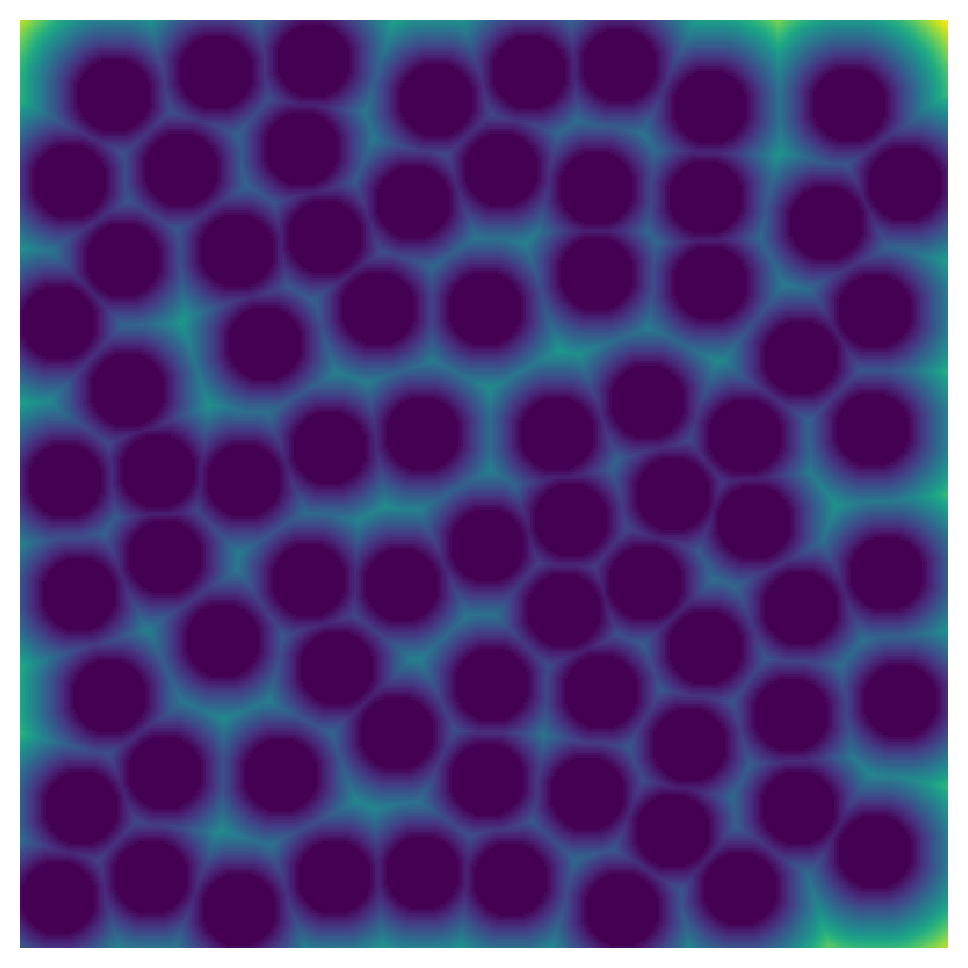

In [4]:
plt.figure(figsize=[5, 5])
plt.imshow(im * dt)
plt.axis('off');

# `sk`

In some cases, the user may already have a reliable skeleton from other image processing packages such as imagej. In those cases, we provide the option for the user to pass in their own skeleton for network extraction to avoid the computational expense of calculating it a second time. If provided, the skeleton will undergo a check for hallow shells using the `ps.networks._magnet._check_skeleton_health` function.

By default, `magnet` will compute it's own skeleton as a wrapper aroung sci-kit image's `skeletonize` function. Here we show the skeleton that is calculated using sci-kit image's skeletonize function.

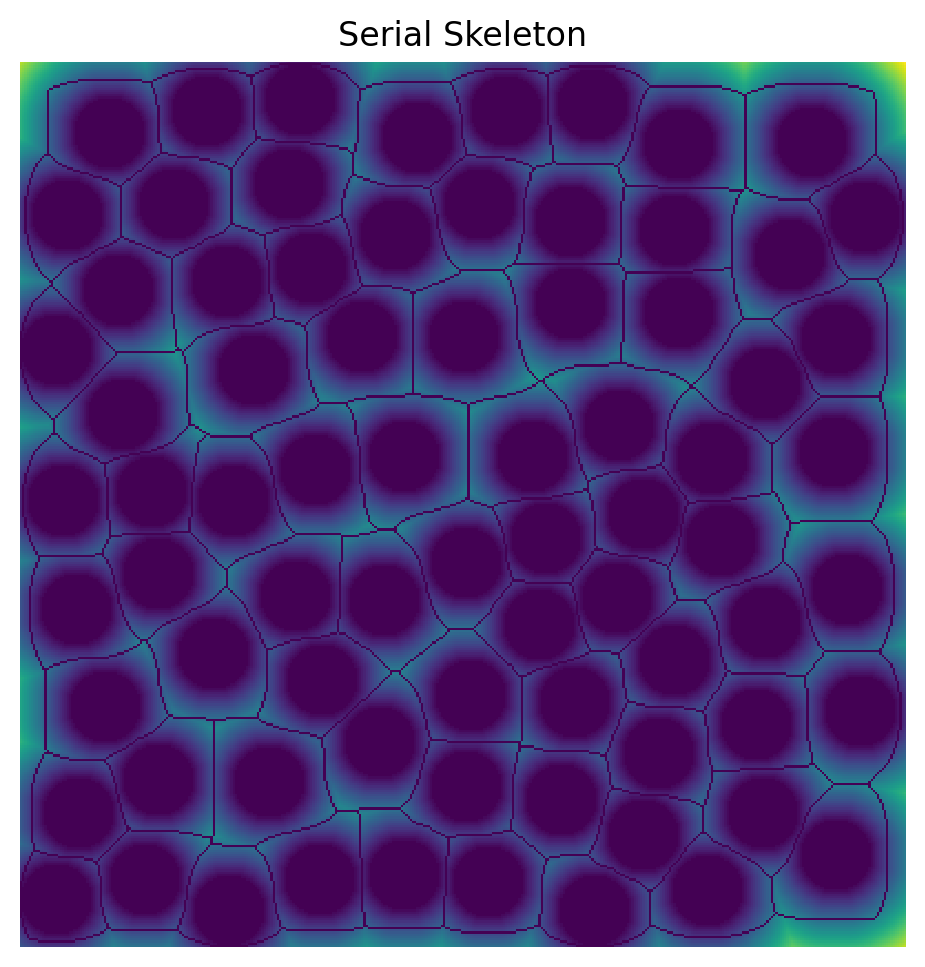

In [5]:
sk = ski.morphology.skeletonize(im)
plt.figure(figsize=[5, 5])
plt.title('Serial Skeleton')
plt.imshow(~sk*im*dt)
plt.axis('off');

# `parallel_kw`

This argument controls whether to calculate the skeleton in parallel or serial modes. By default, this argument is set to `None` meaning that the skeleton will be computed in a serial manner. However, the user can choose to calculate the skeleton in parallel by providing a dictionary with the settings used to control how the parallelization is performed. The parallelization is performed using chunking by dask and therefore, requires specifying the number of divisions in each axis used for chunking the image (`divs`), the amount of overlap to use between chunks (`overlap`), and the number of cores to use (`cores`). It is important to know that the amount of overlap you use is important for ensuring that the parallel skeleton is exactly the same as the serial version. Therefore, careful determination of overlap should be made. In general, it is recommended to use 2 to 3 times the maximum distance transform value of the image. The necessary settings for parallelization are passed by a dictionary of the form, `parallel_kw = {'divs': 2, 'overlap': None, 'cores': None}`

Here is an example of performing the skeleton in parallel by dividing our 400 by 400 image into 4 chunks and using an overlap that is 2 times the maximum distance transform value. By setting cores to `None`, all available cores as determined from `porespy.settings.ncores` will be assumed.

/Users/jeffgostick/Library/CloudStorage/Dropbox/Flash Sync/Code/Git/PoreSpy/.venv/lib/python3.12/site-packages/dask/array/utils.py:142: FutureWarning: `skeletonize_3d` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.morphology.skeletonize` instead.
  meta = func(*args_meta, **kwargs_meta)
/Users/jeffgostick/Library/CloudStorage/Dropbox/Flash Sync/Code/Git/PoreSpy/.venv/lib/python3.12/site-packages/dask/array/core.py:489: FutureWarning: `skeletonize_3d` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.morphology.skeletonize` instead.
  o = func(*args, **kwargs)
/Users/jeffgostick/Library/CloudStorage/Dropbox/Flash Sync/Code/Git/PoreSpy/.venv/lib/python3.12/site-packages/dask/_task_spec.py:764: FutureWarning: `skeletonize_3d` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.morphology.skeletonize` instead.
  return self.func(*new_argspec)


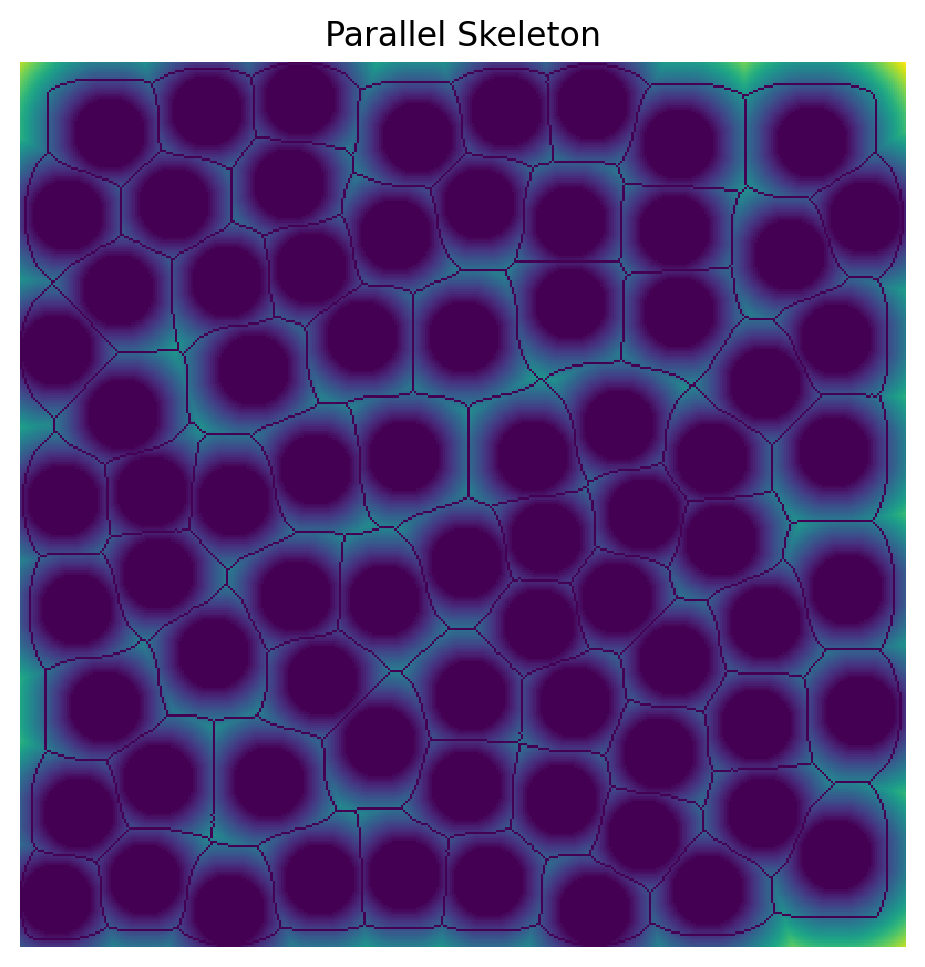

In [6]:
overlap = 2*np.max(dt)
sk_p = ps.networks.skeleton_parallel(im, parallel_kw={'divs': 2, 'overlap': overlap, 'cores': None})
plt.figure(figsize=[5, 5])
plt.title('Parallel Skeleton')
plt.imshow(~sk_p*im*dt)
plt.axis('off');

# `surface`

When taking the skeleton of an image in 3D, it is possible for the skeleton to form shells around "floating solids". Floating solids are common in artifically generated images but can also be caused by improper segmentation of real images of porous media. Therefore, it is important to remove floating solids prior to taking the skeleton. `magnet` removes floating solids from the passed image automatically using the `ps.filters.trim_floating_sold` function. While the skeleton does not form shells around floating solids attached to the edge of an image, the `surface` option is used to control whether or not these floating solids are also removed. Keep in mind that removing floating solids from the surface of the image will further alter the original image, effecting skeletonization and therefore the resulting network extraction, in particular the network at the image boundaries! The default option for removing `surface` floating solids is False.

*This option is strictly used for 3D images and therefore, we do not demonstrate on our 2D example here.

# `s`

After taking the skeleton, the junctions and endpoints of the skeleton are found using convolution. Please note that, in this example, there are no endpoints only junctions! After finding all the junctions, nearby junctions points are merged. The argument `s` controls  to what degree junction points are considered near. If a scalar value is passed, then a hard threshold is assumed. For instance, in the example below, a scalar value of 10 is tried meaning that junctions within 10 voxels of each other are merged into one junction. See the two plots, before merging and after merging, to see how choosing s=10, effects merging. Alternatively, instead of a hard threshold, the distance transform can be used to control which values are considered near. This is the default option available, which is used when `None` is passed for `s`.  In the images below, the junctions and merged junction voxels are coloured in yellow!

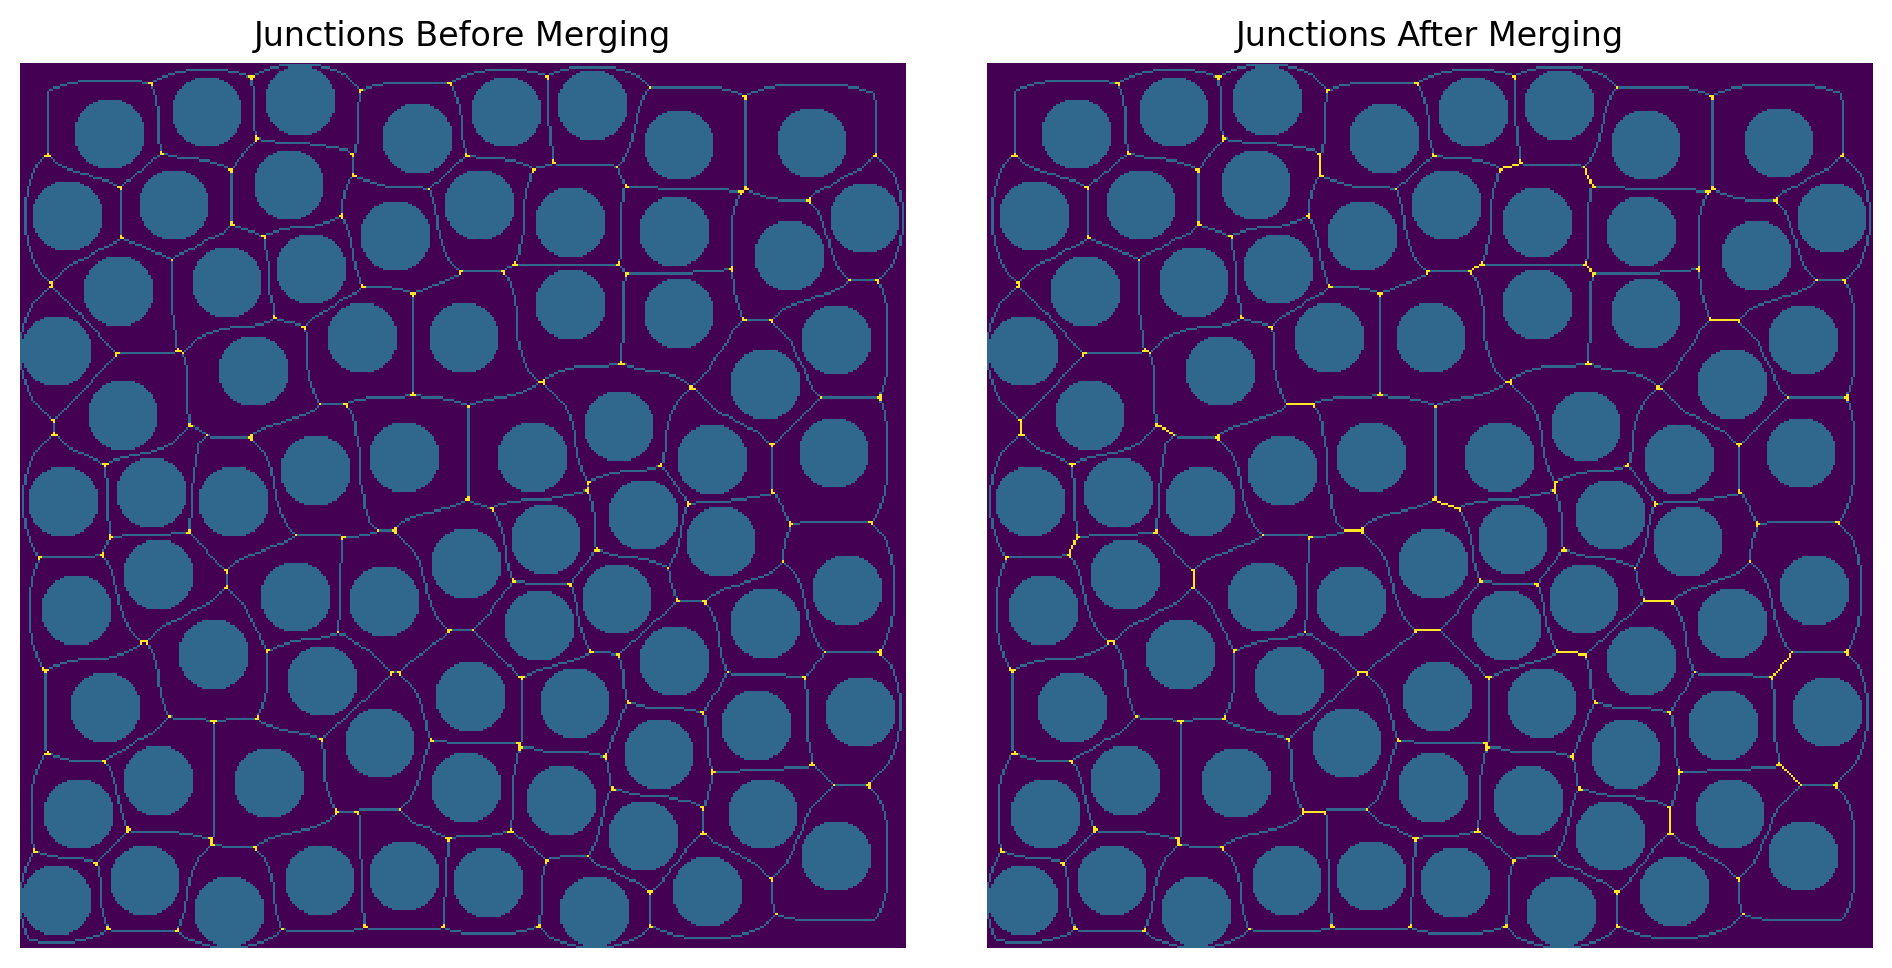

In [7]:
s = 10
fj = ps.networks.find_junctions(sk)
juncs = fj.juncs.copy()
juncs_m = ps.networks.merge_nearby_juncs(sk, fj.juncs, dt=s)

fig, ax = plt.subplots(1, 2, figsize=[10, 5])
ax[0].imshow(juncs*2 + sk + ~im, origin='lower', interpolation='none')
ax[0].set_title('Junctions Before Merging')
ax[0].axis('off')
ax[1].imshow(juncs_m*2 + sk + ~im, origin='lower', interpolation='none')
ax[1].set_title('Junctions After Merging')
ax[1].axis('off');

# `throat_junctions`

One of the drawbacks of the medial axis for network extraction, is that when you find pores as junctions or endpoints in the skeleton only, you miss finding pores that have a connectivity of two. To overcome this limitation, we developed a couple of different ways to find junctions along long throats.  The argument `throat_junctions` controls which mode is used for finding throat junctions. The options are `maximum filter` or `fast marching`. In the first option, a maximum filter is used to find local maximum along throats. In the second option, the fast marching method is used to find peaks in the distance transform along throats. By default, `None` is passed, which means that no throat junctions are found. Here is an example of using the fast marching method to find throat junctions!  In the resulting image, throat junctions are yellow while the original junctions are green.

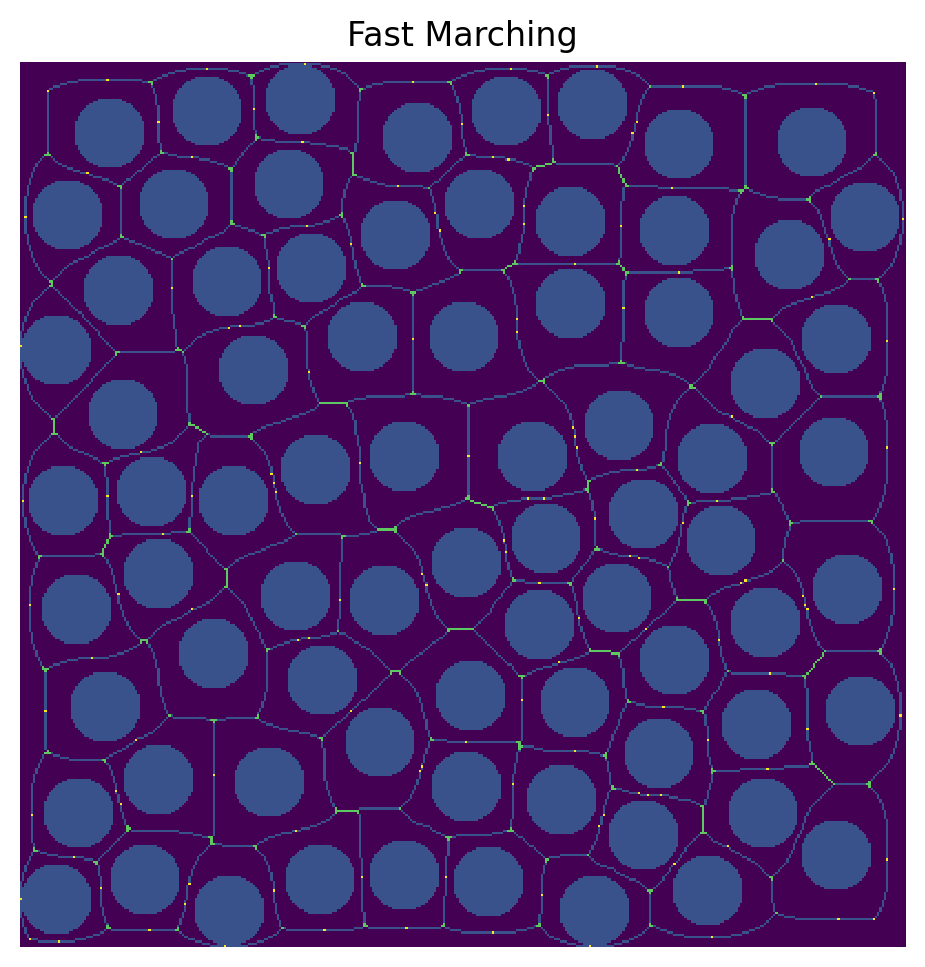

In [9]:
throats = (~juncs_m) * sk
ftj = ps.networks.find_throat_junctions(
    im, sk, juncs_m, throats, dt, mode="maximum filter")
plt.figure(figsize=[5, 5])
plt.imshow(ftj.new_juncs.astype('bool')*3 + juncs_m*2 + sk + ~im)
plt.title('Fast Marching')
plt.axis('off');

# `l_max`

This option controls the size of the maximum filter to use when you use the `maximum filter` option to find junctions along throats. A scalar value is passed with a default value of 7. The value corresponds to the length of one side of a square kernel. A larger maximum filter will find fewer throat junctions than a small maximum filter. Below, we try different `l_max` and explore the effects of choosing different sizes.

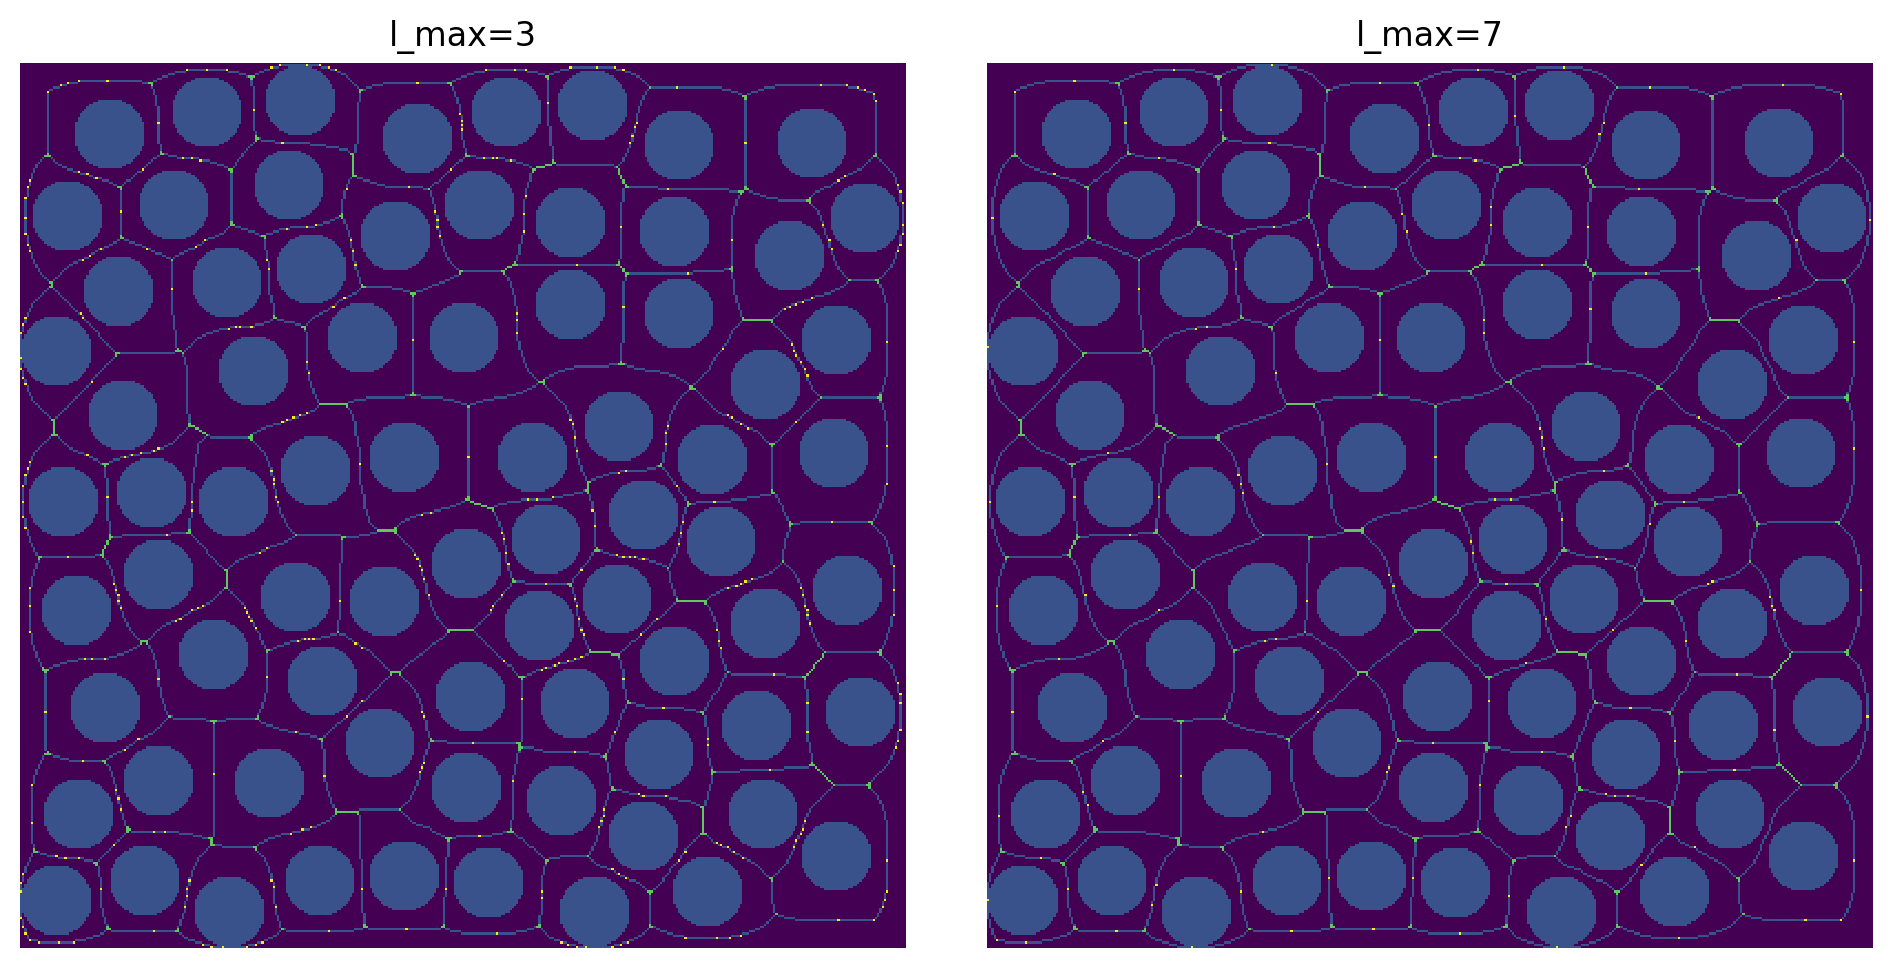

In [11]:
ftj1 = ps.networks.find_throat_junctions(
    im, sk, juncs_m, throats, dt, l_max=3, mode="maximum filter")
ftj2 = ps.networks.find_throat_junctions(
    im, sk, juncs_m, throats, dt, l_max=7, mode="maximum filter")

fig, ax = plt.subplots(1, 2, figsize=[10, 5])
ax[0].imshow(ftj1.new_juncs.astype('bool')*3 + juncs_m*2 + sk + ~im, origin='lower', interpolation='none')
ax[0].set_title('l_max=3')
ax[0].axis('off')
ax[1].imshow(ftj2.new_juncs.astype('bool')*3 + juncs_m*2 + sk + ~im, origin='lower', interpolation='none')
ax[1].set_title('l_max=7')
ax[1].axis('off');

# `throat_area`

This argument controls whether or not to calculate the throat area. By default, `magnet` does not calculate the throat area because it is computationally expensive. However, it may be essential in order to obtain accurate geometric properties. If you want to calculate the throat area, set this argument to `True`. This involves passing some additonal arguments including the nuber of walkers (`n_walkers`), the step size each walker is to take (`step_size`), and the maximum number of steps (`max_n_steps`).

An image containing True at every voxel to calculate the throat area is first created and passed into `get_throat_area` as nodes. Those voxels at which to calculate the throat area are found by findg the voxels along each throat that has the smallest distance transform value.

In [12]:
dt_inv = 1/spim.gaussian_filter(dt, sigma=0.4)
nodes = ps.networks.juncs_to_pore_centers(throats, dt_inv)
throat_area = ps.networks.get_throat_area(im, sk, nodes, n_walkers=10, step_size=0.5, max_n_steps=None)

Finally, we can use the skeleton, junctions, and throat area we previoulsy calculated to compute all the important topological and geometric properties of the pore network. We calculate and combine all of these properties into one dictionary using the `ps.networks.junctions_to_network` method. Here, we use the junctions as merged without any throat junctions.

In [13]:
net = ps.networks.junctions_to_network(sk, juncs_m, throats, dt, throat_area)
net = op.io.network_from_porespy(net)

Let's visualize the resulting network

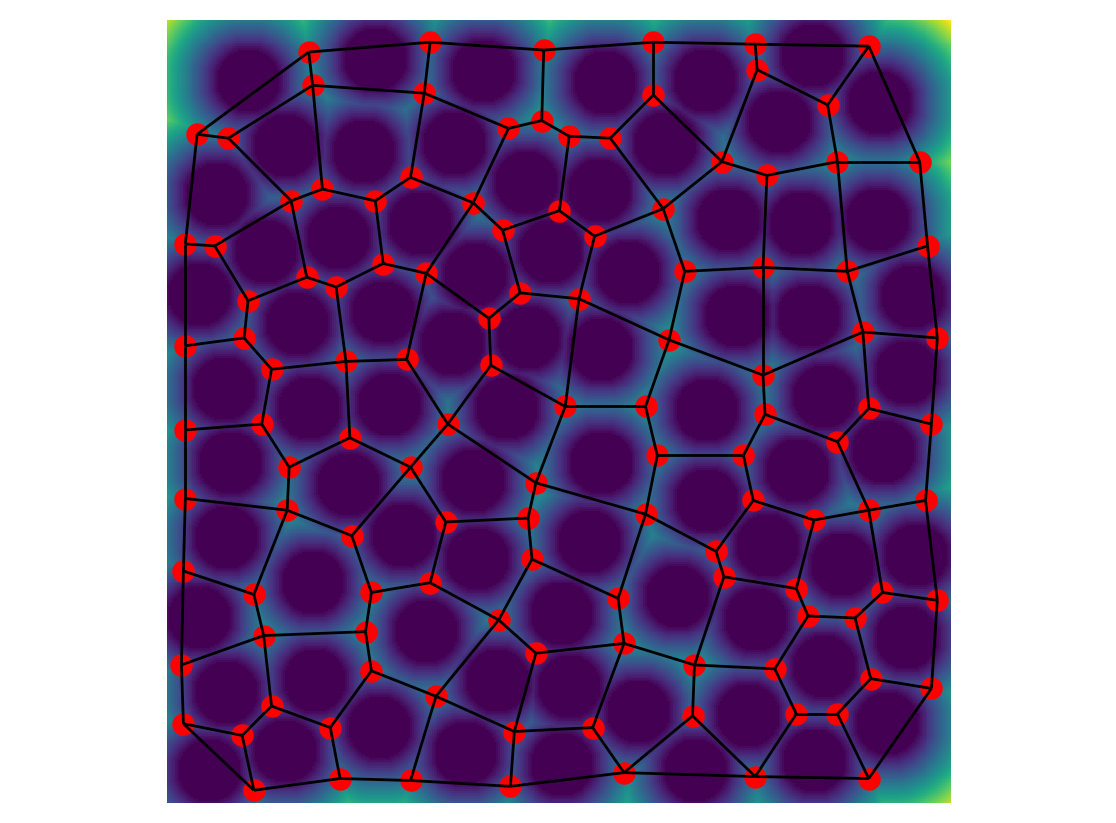

In [14]:
ax = op.visualization.plot_connections(net, throats=net['throat.all'], c='k')
ax = op.visualization.plot_coordinates(net, pores=net['pore.all'], c='r', markersize=50, ax=ax)
fig, ax = plt.gcf(), plt.gca()
ax.imshow(im.T * dt.T)
ax.axis(False);